In [4]:
import argparse
import gc
import os
from datetime import datetime
import matplotlib.pyplot as plt


import numpy as np
import scipy.io as io
import torch
from torch import nn

from tqdm import tqdm

from network import *
from loss import SpectralLoss, StructuralLoss

from tools.spectral_tools import gen_mtf, normalize_prisma, denormalize_prisma

from dataset import open_mat
from config_dict import config
from tools.cross_correlation import local_corr_mask


In [5]:

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # e.g., '20250612_142735'

# TODO put this in a yml file please
# TODO implement early stopping



class Config:
    def __init__(self, config):
        for key, value in config.items():
            setattr(self, key, value)


class EarlyStopping:
    def __init__(self, patience, delta=0, relative=False):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.no_improvement_count = 0
        self.stop_training = False
        self.relative = relative 

    def check_early_stop(self, loss):
        if self.best_loss is None:
            self.best_loss = loss
            self.no_improvement_count = 0
            return

        if not self.relative:
            improvement = loss < self.best_loss - self.delta
        else:
            improvement = (self.best_loss - loss) / self.best_loss > self.delta

        if improvement:
            self.best_loss = loss
            self.no_improvement_count = 0
        else:
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                self.stop_training = True



In [ ]:

def test_r_pnn(args):

    # Paths and env configuration
    basepath = args["input"]
    method = "R-PNN"
    out_dir = os.path.join(args["out_dir"], method, timestamp)

    gpu_number = args["gpu_number"]
    use_cpu = args["use_cpu"]

    # Training hyperparameters
    learning_rate = args["learning_rate"]

    # Satellite configuration
    sensor = config["satellite"]
    ratio = args["ratio"]

    # Environment Configuration
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_number)

    # Devices definition
    device = torch.device(
        "cuda:0" if torch.cuda.is_available() and not use_cpu else "cpu"
    )

    if sensor == "PRISMA":
        normalize = normalize_prisma
        denormalize = denormalize_prisma
    else:
        raise "Satellite not supported"

    # Open the image

    pan, ms_lr, ms, _, wl = open_mat(basepath)

    # move to device
    ms_lr = ms_lr.to(device)
    ms = ms.to(device)
    pan = pan.to(device)

    net_scope = args["net_scope"]
    pad = nn.ReflectionPad2d(net_scope)

    # Torch configuration
    net = R_PNN_model3x3_res(scope = net_scope).to(device)

    if args["pretrained"]:
        weight_path = os.path.join("weights", "R-PNN_" + sensor + ".tar")
        if os.path.exists(weight_path):
            net.load_state_dict(torch.load(weight_path, map_location=device))
            print("Pretrained weights loaded.")
        else:
            raise FileNotFoundError(f"Pretrained weights not found at {weight_path}")
    else:
        print("Skipping weight loading — training from scratch.")

    criterion_spec = SpectralLoss(
        # gen_mtf(ratio, sensor, kernel_size=61, nbands=1), ratio, device
        gen_mtf(ratio, sensor, kernel_size=args["mtf_kernel_size"], nbands=1),
        ratio,
        device,
    ).to(device)
    criterion_struct = StructuralLoss(ratio).to(device)

    optim = torch.optim.Adam(net.parameters(), lr=learning_rate)

    history_loss_spec = []
    history_loss_struct = []

    # alpha = config["alpha_1"]
    alpha = args["alpha"]

    fused = []

    for band_number in range(ms.shape[1]):

        # Reinitialize early stopping for each band
        early_stopping = EarlyStopping(patience=config["patience"], delta=config["delta"], relative = config["relative"])

        band = ms[:, band_number : band_number + 1, :, :].to(device) # selects band_number band but keeps the channel dimension
        band_lr = ms_lr[:, band_number : band_number + 1, :, :].to(device)

        # Aux data generation
        inp = torch.cat([band, pan], dim=1)
        inp = pad(inp)

        threshold = local_corr_mask(inp, ratio, sensor, device, config["semi_width"])

        ft_epochs = int(args["epochs"])

        min_loss = torch.inf
        print("Band {} / {}".format(band_number + 1, ms.shape[1]))
        pbar = tqdm(range(ft_epochs))

        for epoch in pbar:

            pbar.set_description("Epoch %d/%d" % (epoch + 1, ft_epochs))

            net.train()
            optim.zero_grad()

            outputs = net(inp)

            loss_spec,_ = criterion_spec(outputs, band_lr)
            loss_struct, loss_struct_without_threshold = criterion_struct(
                outputs,
                pan,
                threshold[:, :, net_scope:-net_scope, net_scope:-net_scope],
            )

            loss = loss_spec + alpha * loss_struct

            loss.backward()
            optim.step()

            running_loss_spec = loss_spec.item()
            running_loss_struct = loss_struct_without_threshold

            history_loss_spec.append(running_loss_spec)
            history_loss_struct.append(running_loss_struct)

            if loss.item() < min_loss:
                min_loss = loss.item()
                if not os.path.exists("temp"):
                    os.makedirs(os.path.join("temp"))
                torch.save(
                    net.state_dict(), os.path.join("temp", "R-PNN_best_model.tar")
                )

            pbar.set_postfix(
                {"Spec Loss": running_loss_spec, "Struct Loss": running_loss_struct}
            )
            if epoch > config["min_epochs"]:
                early_stopping.check_early_stop(loss.item())
                if early_stopping.stop_training:
                    break
            


            
        # DEBUGGING
        # if band_number == 0:
        #     a1 = threshold.detach().cpu().squeeze()
        #     a2 = inp.detach().cpu().squeeze()
        #     a3 = a3.detach().cpu().squeeze()
        #     a4 = outputs.detach().cpu().squeeze()
            
        #     fig, axs = plt.subplots(1,5, figsize = (10,5))
        #     axs[0].imshow(a1) 
        #     axs[0].set_title("Threshold")
        #     axs[1].imshow(a2[0,:,:])
        #     axs[1].set_title("lr_band")
        #     axs[2].imshow(a2[1,:,:])
        #     axs[2].set_title("panchromatic") 
        #     axs[3].imshow(a3)
        #     axs[3].set_title("outputs before training ")
        #     axs[4].imshow(a4)
        #     axs[4].set_title("outputs after training")

        #     fig1, axs1 = plt.subplots(1,2, figsize = (10,5))
        #     axs1[0].plot(history_loss_struct) 
        #     axs1[0].set_title("history_loss_struct")
        #     axs1[1].plot(history_loss_spec)
        #     axs1[1].set_title("history_loss_spec")
        #     plt.tight_layout()
        #     plt.show()
            

        net.load_state_dict(torch.load(os.path.join("temp", "R-PNN_best_model.tar")))

        net.eval()
        fused.append(net(inp).detach().cpu())

    fused = torch.cat(fused, 1)

    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    save_path = os.path.join(
         out_dir, basepath.split(os.sep)[-1].split(".")[0] + "_R-PNN.mat"
    )
    io.savemat(save_path, {"I_MS": fused})
    history = {"loss_spec": history_loss_spec, "loss_struct": history_loss_struct}
    io.savemat(
        os.path.join(
            out_dir, basepath.split(os.sep)[-1].split(".")[0] + "_R-PNN_stats.mat"
        ),
        history,
    )

    torch.cuda.empty_cache()
    gc.collect()

    return


test_r_pnn(config)


Skipping weight loading — training from scratch.
Band 1 / 12


Epoch 1284/2000:  64%|██████▍   | 1283/2000 [00:18<00:10, 69.68it/s, Spec Loss=0.0081, Struct Loss=0.0675] 
/tmp/ipykernel_168588/2615726014.py:169: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this ex

Band 2 / 12


Epoch 323/2000:  16%|█▌        | 322/2000 [00:04<00:23, 71.75it/s, Spec Loss=0.00887, Struct Loss=0.0677]


Band 3 / 12


Epoch 174/2000:   9%|▊         | 173/2000 [00:02<00:25, 70.60it/s, Spec Loss=0.00933, Struct Loss=0.0677]


Band 4 / 12


Epoch 248/2000:  12%|█▏        | 247/2000 [00:03<00:24, 72.35it/s, Spec Loss=0.0101, Struct Loss=0.0651]


Band 5 / 12


Epoch 376/2000:  19%|█▉        | 375/2000 [00:05<00:22, 72.48it/s, Spec Loss=0.0121, Struct Loss=0.0591]


Band 6 / 12


Epoch 152/2000:   8%|▊         | 151/2000 [00:02<00:25, 73.03it/s, Spec Loss=0.0124, Struct Loss=0.0578]


Band 7 / 12


Epoch 152/2000:   8%|▊         | 151/2000 [00:02<00:25, 72.57it/s, Spec Loss=0.0126, Struct Loss=0.0568]


Band 8 / 12


Epoch 152/2000:   8%|▊         | 151/2000 [00:02<00:25, 72.90it/s, Spec Loss=0.0128, Struct Loss=0.0567]


Band 9 / 12


Epoch 201/2000:  10%|█         | 200/2000 [00:02<00:24, 73.34it/s, Spec Loss=0.0128, Struct Loss=0.0569]


Band 10 / 12


Epoch 152/2000:   8%|▊         | 151/2000 [00:02<00:24, 74.07it/s, Spec Loss=0.0128, Struct Loss=0.0571]


Band 11 / 12


Epoch 152/2000:   8%|▊         | 151/2000 [00:02<00:25, 72.72it/s, Spec Loss=0.013, Struct Loss=0.0573] 


Band 12 / 12


Epoch 152/2000:   8%|▊         | 151/2000 [00:02<00:25, 73.09it/s, Spec Loss=0.0132, Struct Loss=0.0577]


In [8]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import scipy.io as io
import cv2

import base64
from io import BytesIO
from PIL import Image

from tools.hsi_to_rgb import hsi_to_rgb

In [9]:
def np_normalize(array):
    return (array-np.min(array)) /(np.max(array) - np.min(array))

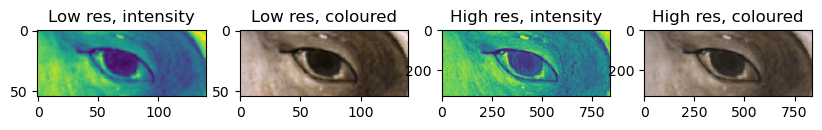

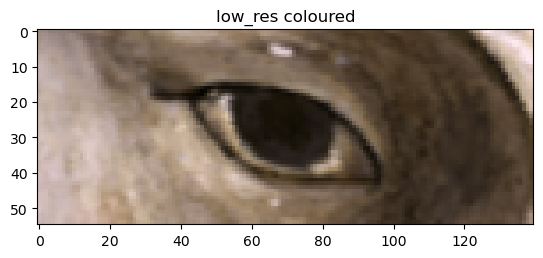

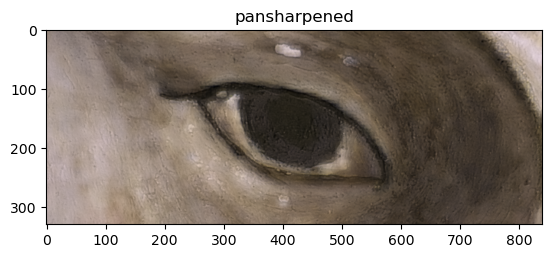

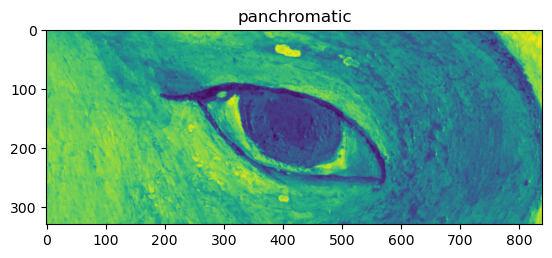

In [10]:
#tmp = io.loadmat(r"C:\Users\frcar\Desktop\Git Projects\R-PNN-main\aviva_eye_aligned_copy.mat")
mat_in = io.loadmat(config["input"])

wl_cal = np.squeeze(mat_in["Wavelengths"].astype("float32"))
wl_cal = wl_cal[::100]

ms = mat_in["I_MS_LR"].astype("float32")
ms = np_normalize(ms)

hr_img = mat_in["I_PAN"].astype("float32")
hr_img = np_normalize(hr_img)

# tmp = io.loadmat(r"Outputs\R-PNN\20250612_112930\aviva_eye_aligned_copy_R-PNN.mat")
mat_out = io.loadmat(r"Outputs/R-PNN/20250630_134921/aviva_eye_aligned_r6_rwl_R-PNN.mat")
# mat_out = io.loadmat(arguments.save_path)
pansharpened = mat_out["I_MS"].astype("float32")
pansharpened = pansharpened.squeeze().transpose(1,2,0)

lr_img = np.sum(ms,2) # grayscale lr image, float32

# color the ms image
rgb_lr = hsi_to_rgb(ms, wl_cal)
rgb_hr = hsi_to_rgb(pansharpened, wl_cal)

fig, ax = plt.subplots(1,4, figsize = (10,5))
ax[0].imshow(lr_img)
ax[0].set_title("Low res, intensity");
ax[1].imshow(rgb_lr)
ax[1].set_title("Low res, coloured");
ax[2].imshow(hr_img)
ax[2].set_title("High res, intensity");
ax[3].imshow(rgb_hr)
ax[3].set_title("High res, coloured");


fig0, ax0 = plt.subplots()
ax0.imshow(rgb_lr)
ax0.set_title("low_res coloured");

fig1, ax1 = plt.subplots()
ax1.imshow(rgb_hr)
ax1.set_title("pansharpened");


fig2, ax2 = plt.subplots()
ax2.imshow(hr_img)
ax2.set_title("panchromatic");

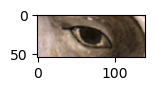

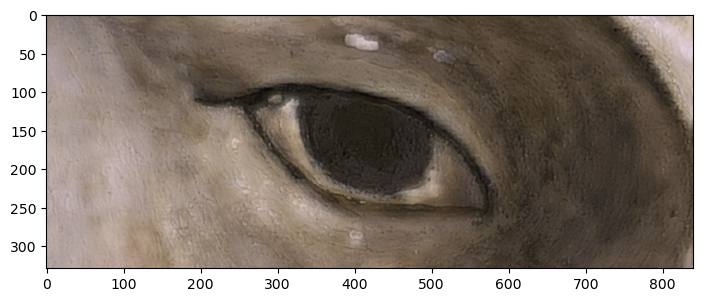

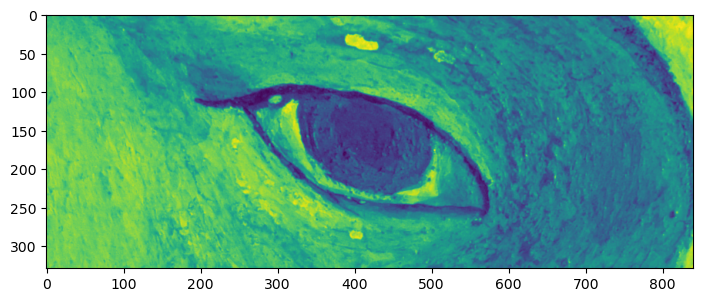

In [11]:
def show_image(img, dpi=100):
    height, width = img.shape[:2]
    figsize = (width / dpi, height / dpi)

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.imshow(img)
    # ax.axis('off')
    plt.show()

# Llamadas
show_image(rgb_lr)
show_image(rgb_hr)
show_image(hr_img)

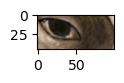

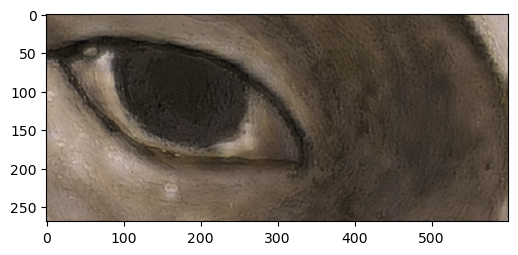

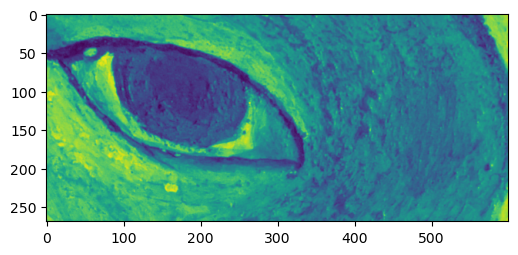

In [12]:
brightness_offset = 0.0
contrast = 1
row_t_0 = 10
row_t_f = 60

col_t_0 = 40
col_t_f = 140


show_image(np.clip(contrast*rgb_lr[row_t_0:row_t_f,col_t_0:col_t_f]+brightness_offset, a_min=0, a_max = 1.0))
show_image(np.clip(contrast*rgb_hr[config["ratio"]*row_t_0:config["ratio"]*row_t_f , config["ratio"]*col_t_0:config["ratio"]*col_t_f]+brightness_offset, a_min=0, a_max = 1.0))
show_image(hr_img[config["ratio"]*row_t_0:config["ratio"]*row_t_f,config["ratio"]*col_t_0:config["ratio"]*col_t_f])

In [15]:
# Analyse the results with polygon selector

In [ ]:
# agument parser


'''
if __name__ == "__main__":
    parser = argparse.ArgumentParser(
        prog="R-PNN Training code",
        formatter_class=argparse.RawDescriptionHelpFormatter,
        description="R-PNN is an unsupervised deep learning-based pansharpening "
        "method.",
        epilog="""\
Reference: 
Band-wise Hyperspectral Image Pansharpening using CNN Model Propagation
G. Guarino, M. Ciotola, G. Vivone, G. Scarpa 

Authors: 
- Image Processing Research Group of University of Naples Federico II ('GRIP-UNINA')
- National Research Council, Institute of Methodologies for Environmental Analysis (CNR-IMAA)
- University of Naples Parthenope

For further information, please contact the first author by email: giuseppe.guarino2[at]unina.it """,
    )
    optional = parser._action_groups.pop()
    required = parser.add_argument_group("required named arguments")

    required.add_argument(
        "-i",
        "--input",
        type=str,
        required=True,
        help="The path of the .mat file"
        "For more details, please refer to the GitHub documentation.",
    )

    optional.add_argument(
        "-o",
        "--out_dir",
        type=str,
        default="Outputs",
        help="The directory in which save the outcome.",
    )

    optional.add_argument(
        "-n_gpu",
        "--gpu_number",
        type=int,
        default=0,
        help="Number of the GPU on which perform the " "algorithm.",
    )
    optional.add_argument(
        "--use_cpu",
        action="store_true",
        help="Force the system to use CPU instead of GPU. It could solve OOM problems, but the "
        "algorithm will be slower.",
    )

    optional.add_argument(
        "-lr",
        "--learning_rate",
        type=float,
        default=-1.0,
        help="Learning rate with which perform the training.",
    )

    optional.add_argument(
        "--pretrained",
        action="store_true",
        help="Load pretrained model weights. If not set, training will start from scratch.",
    )

    parser._action_groups.append(optional)
    arguments = parser.parse_args()
'''